In [6]:

# import tensorflow as tf
# print(tf.config.list_physical_devices('GPU'))
import pandas as pd
import numpy as np
import wfdb
from pathlib import Path
import ast
from wfdb import processing
from scipy.fftpack import fft, ifft 
import pywt as pw
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import Preprocessing
import FeatureExtraction
from importlib import reload
import transformers
import random
from transformers import Transformers
import scipy.signal as signal
from skimage.restoration import denoise_wavelet
from scipy.stats import skew, kurtosis
import statistics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC


loading the signals

In [ ]:
reload(Preprocessing)

load = Preprocessing.preprocess()
x_train, y_train, x_test, y_test = load.loadData()


""" a 3D array of shape (19601, 12, 1000) where the first dimension represents the number of ECG signals,
 the second dimension represents the number of leads, and the third dimension represents the length of each signal. """


 
origin_signals = np.zeros((19601, 12, 1000))
origin_test_signals = np.zeros((2198, 12, 1000))

for sig in range(x_train.shape[0]):
    for lead in range(x_train.shape[2]):
        
        origin_signals[sig, lead, :] = x_train[sig].T[lead][:] 

for sig in range(x_test.shape[0]):
    for lead in range(x_test.shape[2]):
        
        origin_test_signals[sig, lead, :] = x_test[sig].T[lead][:] 



""" highpassedfiltered are just baseline removed """
# loaded_highpassedfiltered_signal = np.load('highpass_filtered.npy')


""" 'bandpass_filtered.npy' contains signals that have been thourogh 
baseline removal + moving avg + bandpass filter [0.5 - 25] """ 

# loaded_bandpassedfiltered_signal = np.load('bandpass_filtered_25.npy')

In [3]:
reload(Preprocessing)

test = Preprocessing.preprocess()

x_train, y_train, x_test, y_test, agg_df = test.loadData()

In [6]:
print(len(agg_df))
print(len(agg_df.index))

44
44


Freq Analysis

In [7]:
loaded_waveletfiltered_signals = np.load('wavelet_filtered.npy')

In [6]:
loaded_waveletfiltered_signals.shape

(19601, 12, 1000)

In [5]:
filter = Preprocessing.preprocess()
sample_highpass_filtered = filter.highpassfilter(origin_signals[0][0], 100, 4, 0.5)
sample_bandpass_filtered = filter.bandpassfilter(origin_signals[0][0], 100, 4, 0.1, 35)
sample_movingavg_filtered = filter.movingaveragefilter(origin_signals[0][0])

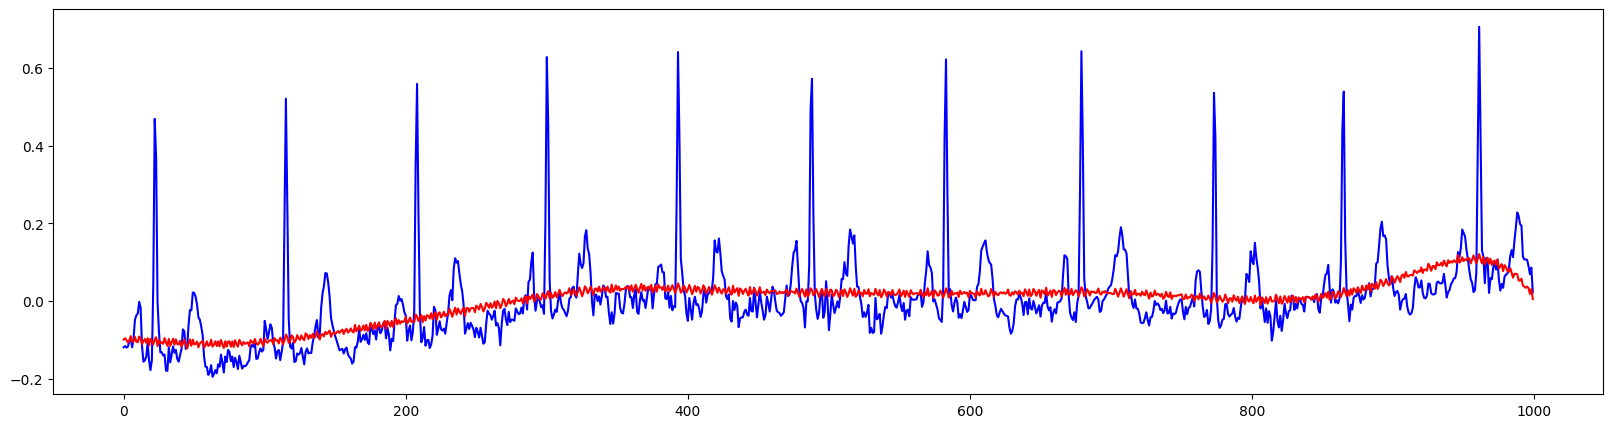

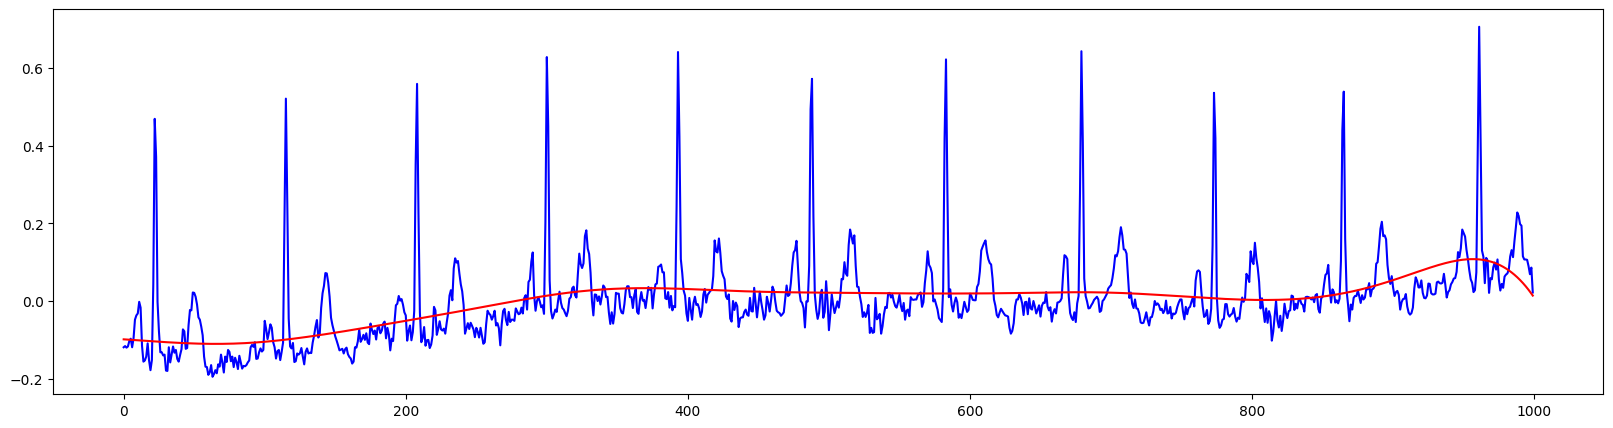

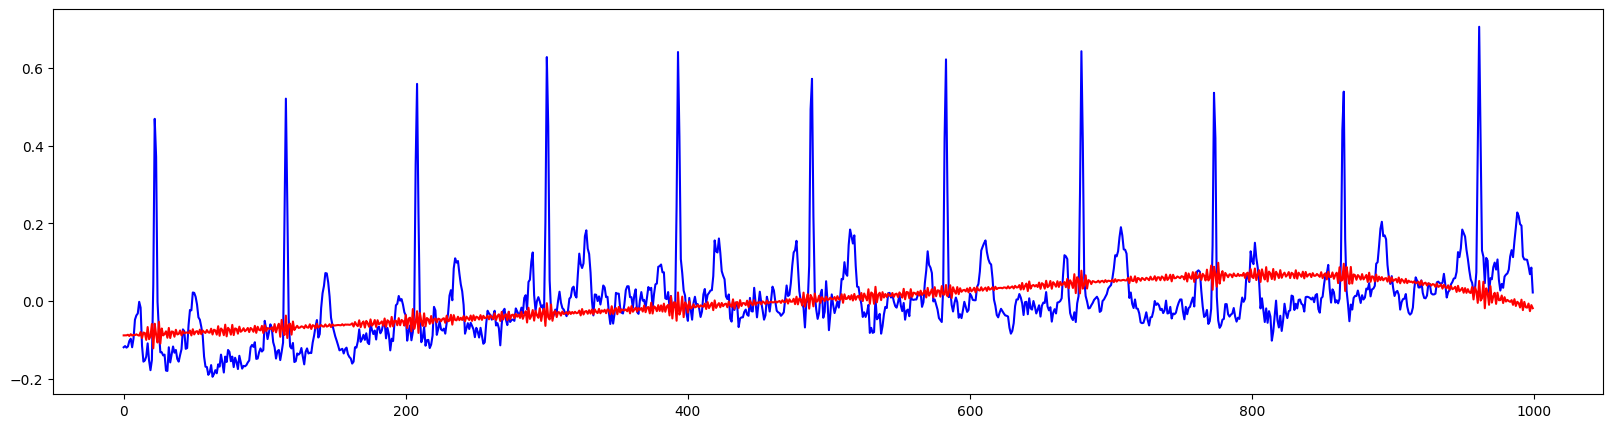

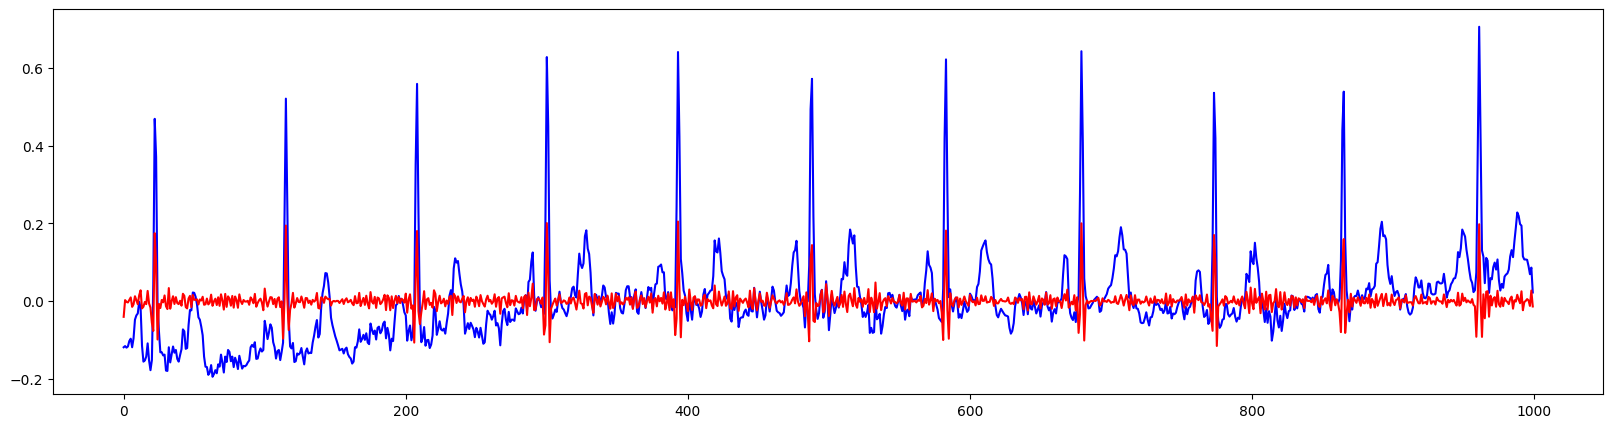

In [8]:
reload(Preprocessing)
show = Preprocessing.preprocess()

show.noise_representation(origin_signals[0][0], loaded_waveletfiltered_signals[0][0])
show.noise_representation(origin_signals[0][0], sample_highpass_filtered)
show.noise_representation(origin_signals[0][0], sample_bandpass_filtered)
show.noise_representation(origin_signals[0][0], sample_movingavg_filtered)

In [ ]:
reload(transformers)
T = Transformers()
T.FFT(origin_signals[0][0][:])

Noise-removal

In [5]:
reload(Preprocessing)

""" all the filtering techniques are applied to the train signals """
filter = Preprocessing.preprocess()

baseline_removed_signals, bandpassfiltered_signals, smoothedfiltered_signals = np.zeros((19601, 12, 1000)), np.zeros((19601, 12, 1000)), np.zeros((19601, 12, 1000))


for sig in range(origin_signals.shape[0]):
    for lead in range(origin_signals.shape[1]):
        

        """ baseline removal """
        baseline_removed_signals[sig][lead] = filter.highpassfilter(origin_signals[sig][lead][:], 100, 4, 0.5)



In [3]:
""" smoothing using wavelets
this changes have been applied to the baseline filtered signals """

reload(Preprocessing)
filter = Preprocessing.preprocess()
waveletfiltered_signals = np.zeros((19601, 12, 1000))


for sig in range(origin_signals.shape[0]):
    for lead in range(origin_signals.shape[1]):

        waveletfiltered_signals[sig][lead] = filter.wavelet_denoising(loaded_highpassedfiltered_signal[sig][lead][:])
        


/home/donya/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/donya/.local/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
for sig in range(origin_signals.shape[0]):
    for lead in range(origin_signals.shape[1]):

        smoothedfiltered_signals[sig][lead] = filter.movingaveragefilter(origin_signals[sig][lead][:])

np.save('movingavg_filtered.npy', bandpassfiltered_signals)
    


In [ ]:

for sig in range(origin_signals.shape[0]):
    for lead in range(origin_signals.shape[1]):

        """ smoothing the variations """
        bandpassfiltered_signals[sig][lead] = filter.bandpassfilter(baseline_removed_signals[sig][lead][:], 100, 4, 0.5, 35)

# np.save('bandpass_filtered.npy', bandpassfiltered_signals)


Extracting Features

In [5]:
"""  
locating the R Peaks for the entire dataset
- R_peaks should have a shape of (19601, 12), representing the R peak locations for each signal and lead.
- RR_intervals should have a shape of (19601, 12), representing the RR intervals for each signal and lead. 

"""


reload(FeatureExtraction)
extractor = FeatureExtraction.QRS()

loaded_waveletfiltered_signals = np.load('wavelet_filtered.npy')
R_peaks = []

for signal in loaded_waveletfiltered_signals:
    signal_r_peaks = []
    for lead in signal:
        r_peaks = extractor.R_peak_detection(lead)
        signal_r_peaks.append(r_peaks)
    R_peaks.append(signal_r_peaks)

RR_intervals = [[np.diff(lead) / extractor.sampling_rate for lead in signal] for signal in R_peaks]


In [8]:
print(len(R_peaks[0]))
print(len(RR_intervals[0]))

12
12


In [9]:

""" 
the HR and HRV are unique for an individual, 
but the measurements obtained from different leads may show slight variations 
due to the specific placement and orientation of the electrodes used to capture the signals

 """
""" 
the lead commonly used for HRV analysis is Lead II.
 """

"""        hrv_features = [
            mean_rr,
            std_rr,
            rmssd, 
            nn50, 
            pnn50, 
            total_power, 
            vlf, 
            lf, 
            hf, 
            lf_norm,
            hf_norm, 
            lf_hf_ratio, 
            lf_hf_ratio_log, 
            total_power_log, 
            lf_hf_ratio_log_norm
        ]
        
        """

reload(FeatureExtraction)
extractor = FeatureExtraction.QRS()

HRV_features = []

for signal in range(loaded_waveletfiltered_signals.shape[0]):
    
    HRV_features.append(extractor.calculate_hrv_features(RR_intervals[signal][1]))


/home/donya/.local/lib/python3.9/site-packages/scipy/signal/_spectral_py.py:1999: UserWarning: nperseg = 256 is greater than input length  = 10, using nperseg = 10
  warnings.warn('nperseg = {0:d} is greater than input length '
/home/donya/Documents/electrocardiogram/ptb-xl/FeatureExtraction.py:140: RuntimeWarning: divide by zero encountered in log
  lf_hf_ratio_log = np.log(lf_hf_ratio)
/home/donya/Documents/electrocardiogram/ptb-xl/FeatureExtraction.py:142: RuntimeWarning: invalid value encountered in double_scalars
  lf_hf_ratio_log_norm = (lf_hf_ratio_log - np.mean(lf_hf_ratio_log)) / np.std(lf_hf_ratio_log)
/home/donya/.local/lib/python3.9/site-packages/numpy/core/_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/home/donya/.local/lib/python3.9/site-packages/scipy/signal/_spectral_py.py:1999: UserWarning: nperseg = 256 is greater than input length  = 5, using nperseg = 5
  warnings.warn('nperseg = {0:d} is greater than input le

/home/donya/.local/lib/python3.9/site-packages/scipy/signal/_spectral_py.py:1999: UserWarning: nperseg = 256 is greater than input length  = 31, using nperseg = 31
  warnings.warn('nperseg = {0:d} is greater than input length '
/home/donya/.local/lib/python3.9/site-packages/scipy/signal/_spectral_py.py:1999: UserWarning: nperseg = 256 is greater than input length  = 29, using nperseg = 29
  warnings.warn('nperseg = {0:d} is greater than input length '


In [10]:
len(HRV_features[0])

15

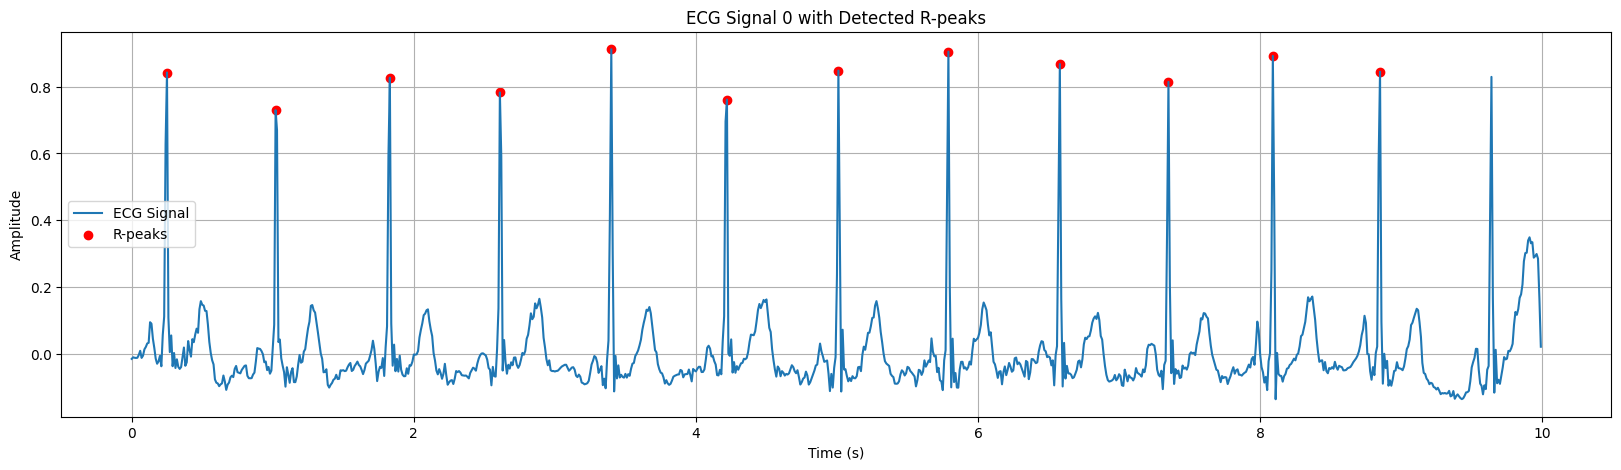

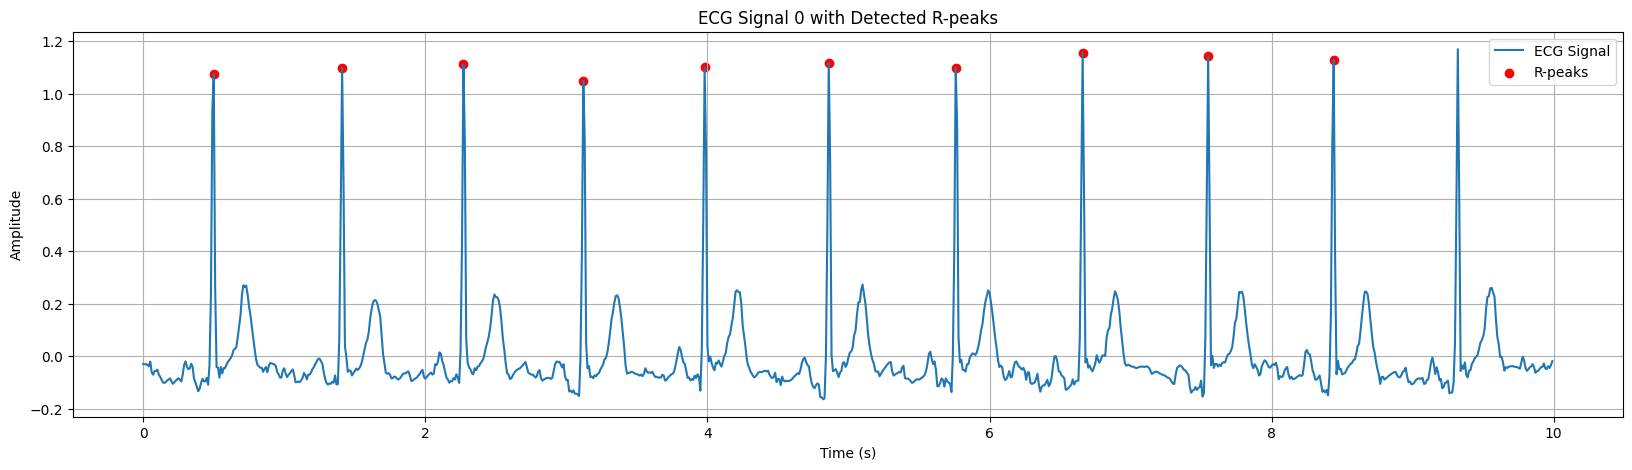

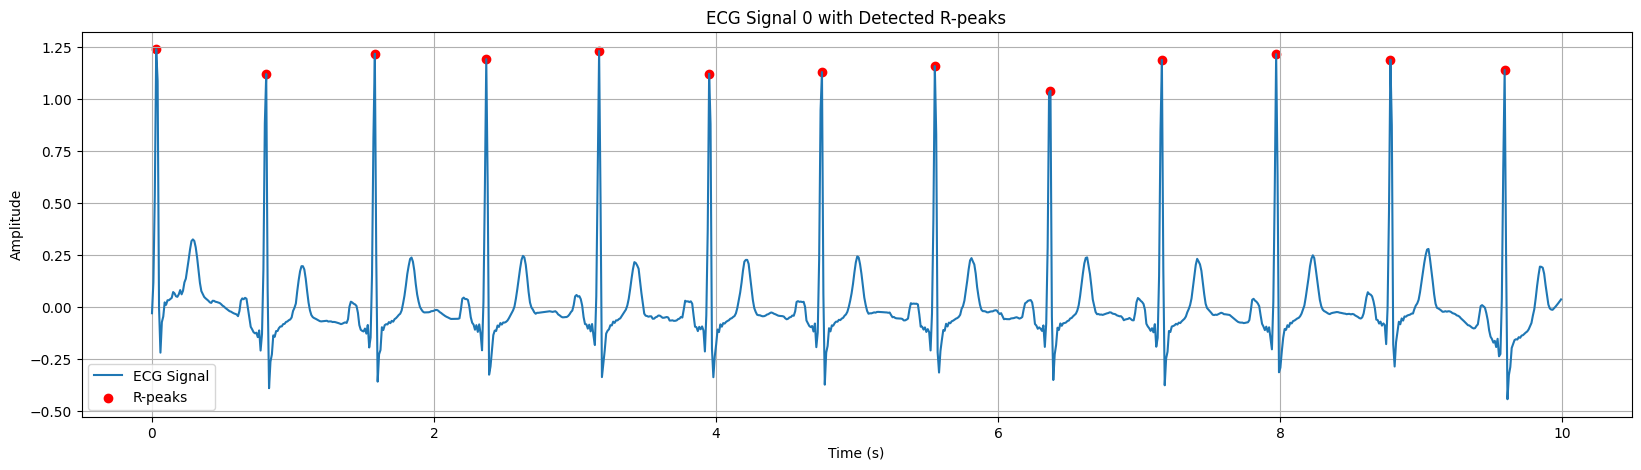

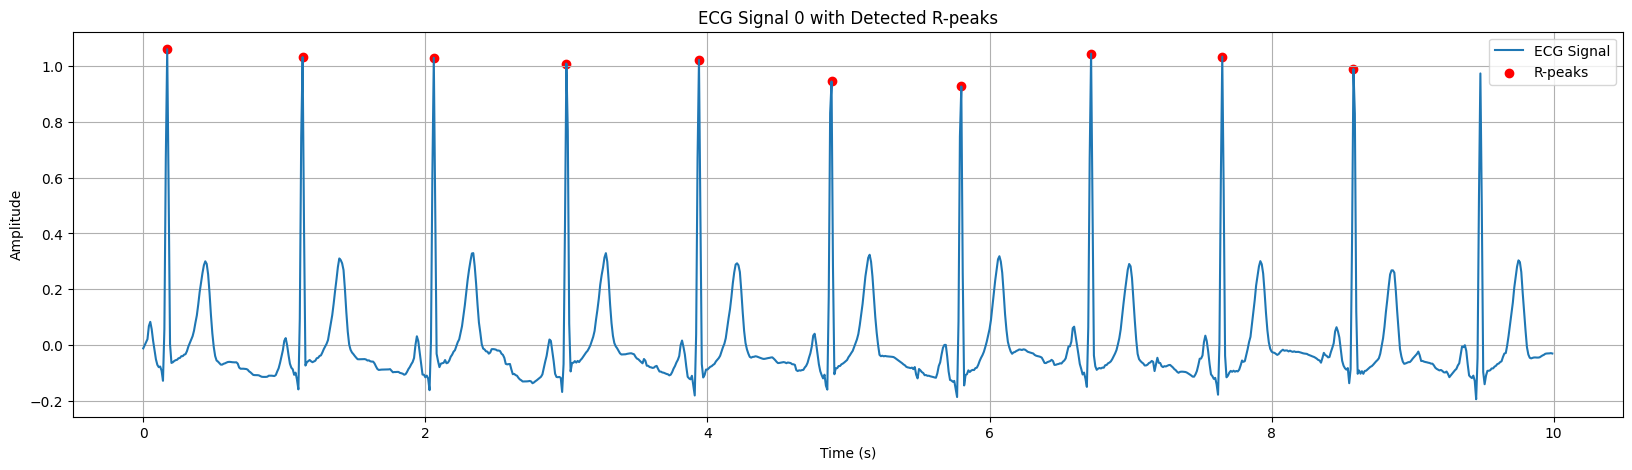

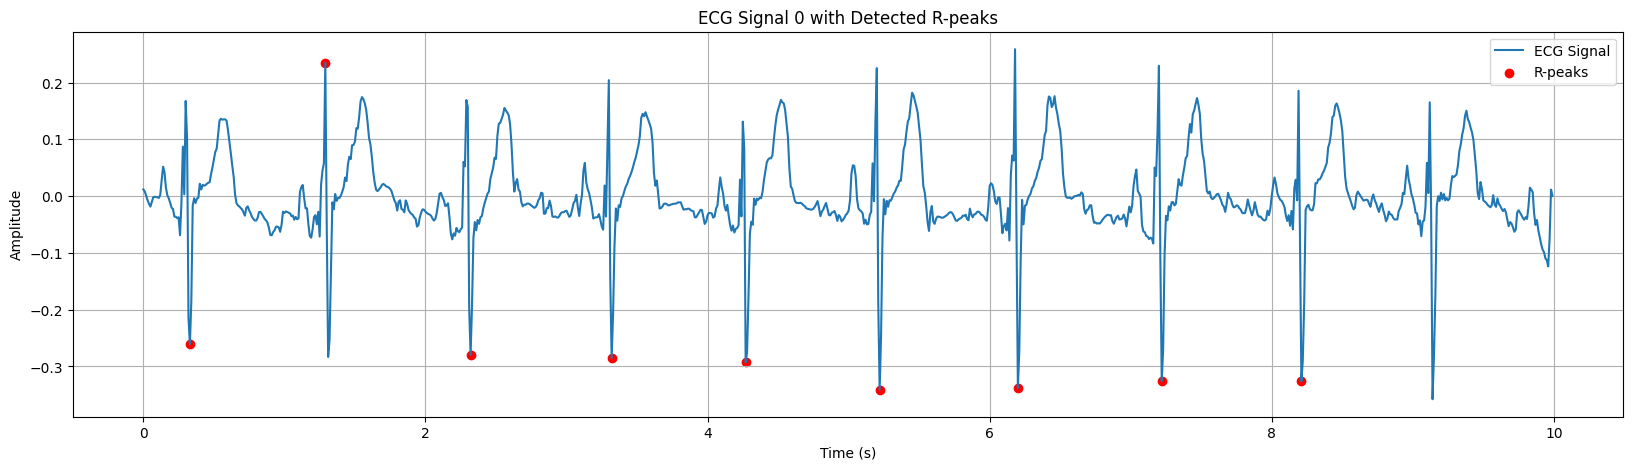

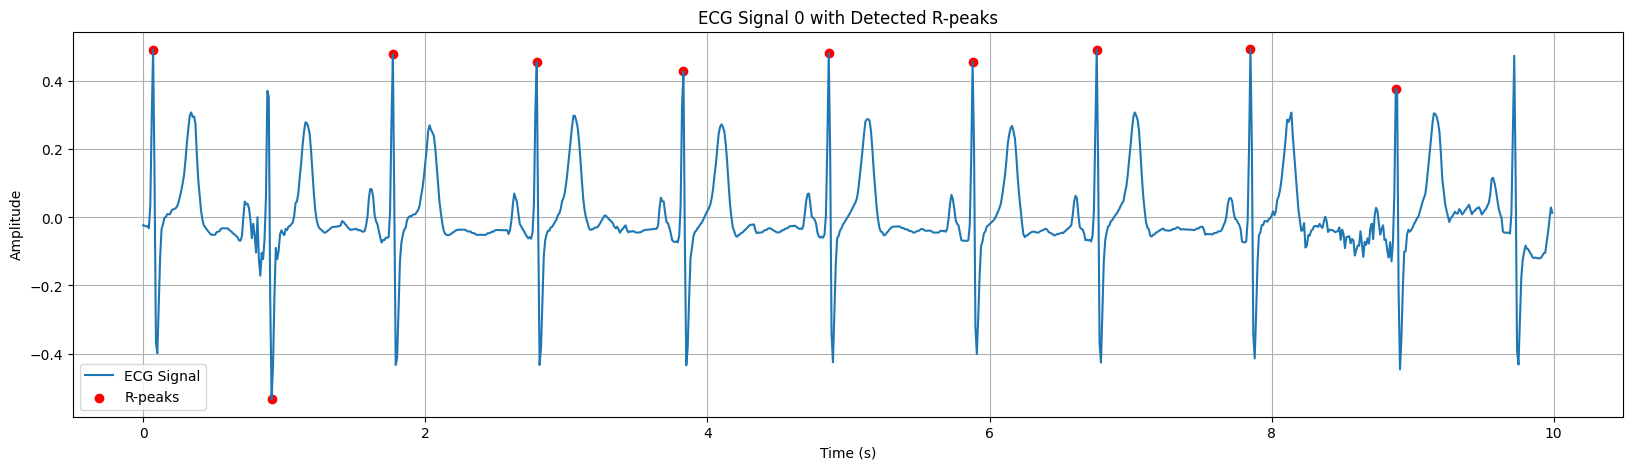

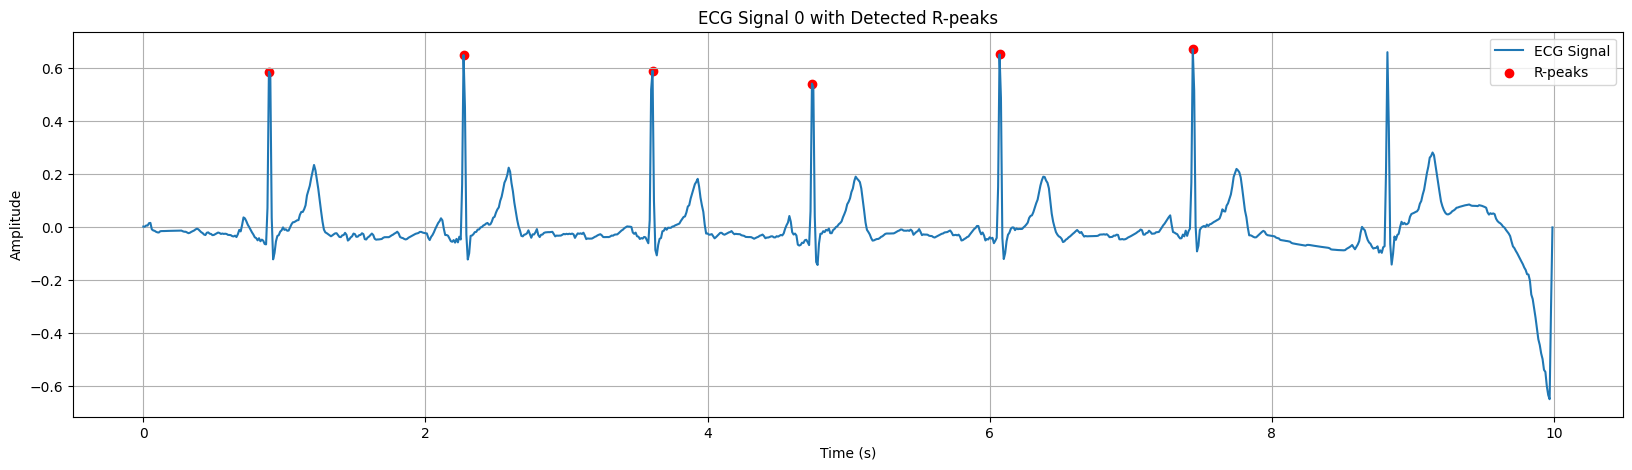

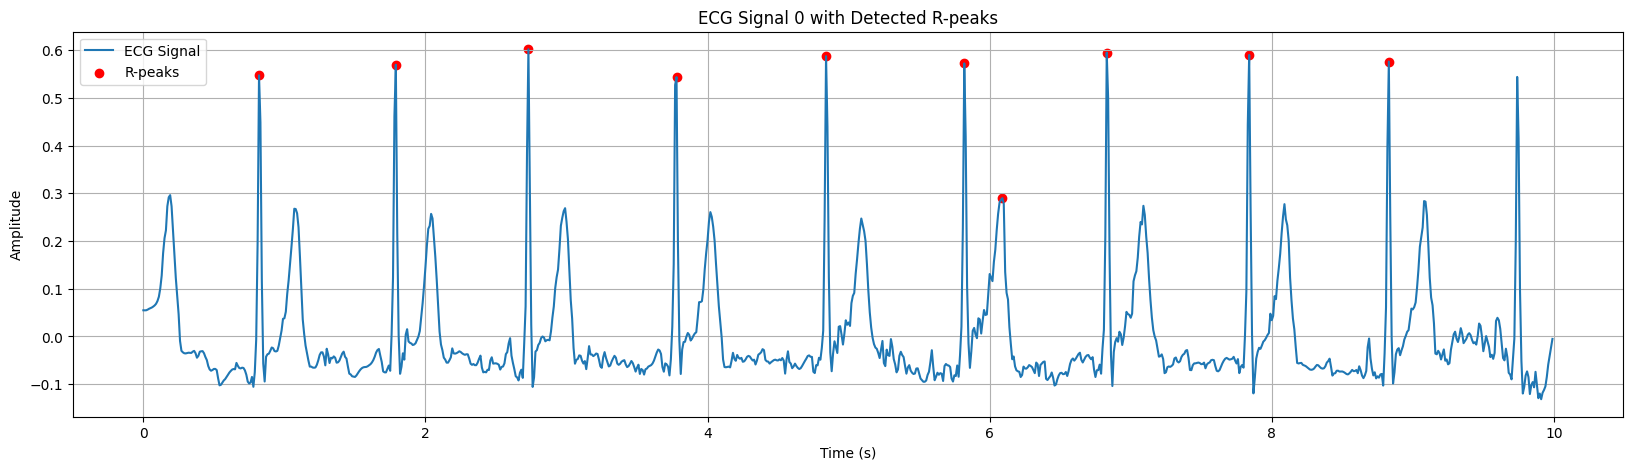

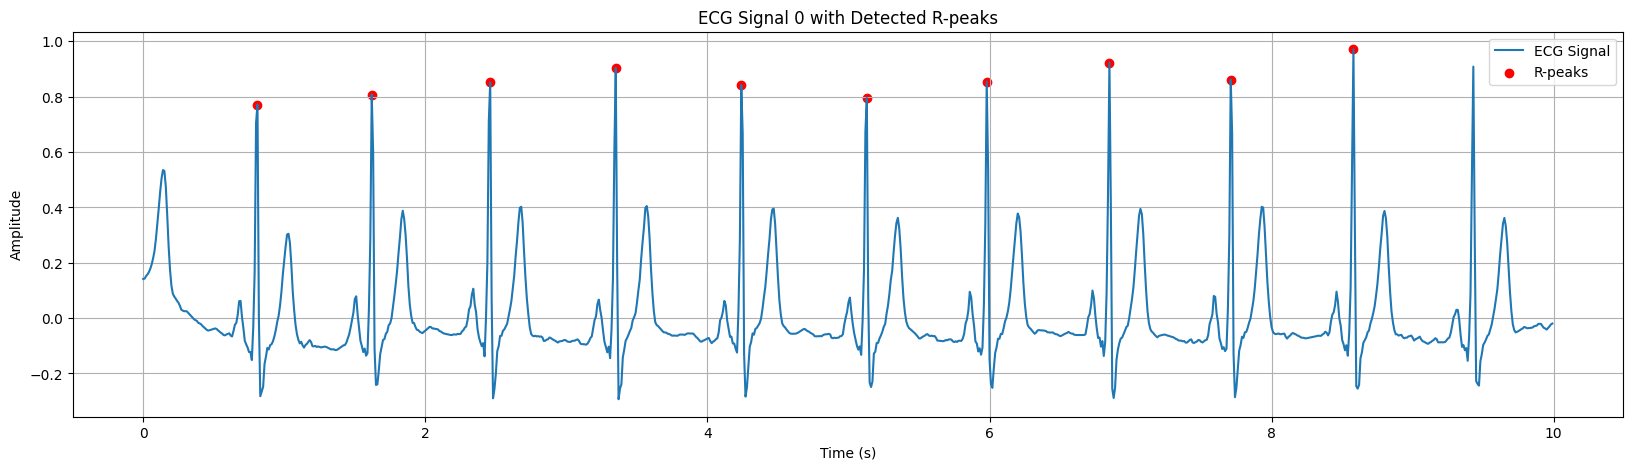

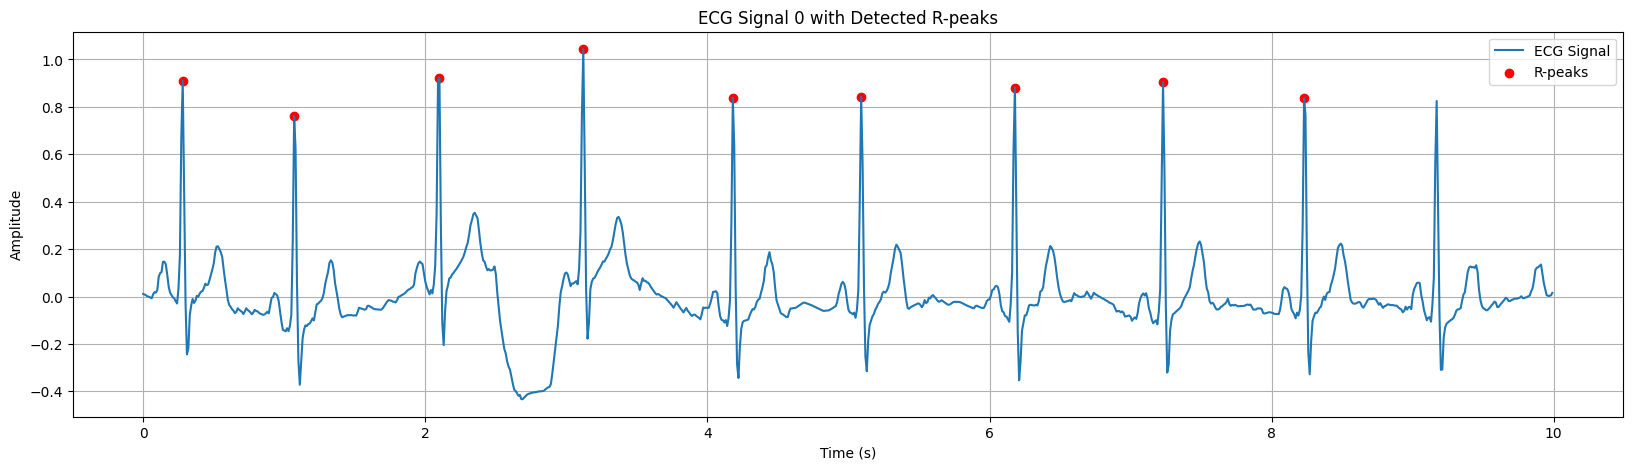

In [12]:
reload(FeatureExtraction)
extractor = FeatureExtraction.QRS()
random_index = [random.randint(0, 100) for i in range(10)]
for index in random_index:
    extractor.R_peak_detection(loaded_waveletfiltered_signals[index][1])

In [10]:
count = 0
for value in y_train_filtered:
    if value == []:
        count = count + 1
count 
        

0

In [5]:
y_train.shape

(19601,)

In [ ]:
# Identify the missing indices
missing_indices = [i for i, label in enumerate(y_train) if len(label) == 0]

# Remove the missing indices from signals and labels
filtered_signals = np.delete(origin_signals, missing_indices, axis=0)
filtered_labels = np.delete(y_train, missing_indices, axis=0)

In [31]:
y_train_flat = [label[0] for label in y_train if len(label) > 0]
len(y_train_flat)

19230

In [18]:
origin_signals = origin_signals.reshape((19601, -1))
origin_signals.shape

(19601, 12000)

In [4]:
loaded_waveletfiltered_signals = loaded_waveletfiltered_signals.reshape((19601, -1))
loaded_waveletfiltered_signals.shape


(19601, 12000)

In [5]:
y_train_filtered = [label for label in y_train if len(label) > 0]

In [8]:
from sklearn.preprocessing import LabelEncoder
import itertools

y_train_flat = list(itertools.chain.from_iterable(y_train))

# Encode the labels
label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train_flat)


In [12]:
len(y_train_encoded)

19230

In [21]:
count = 0
for index in y_train_encoded:
    if index == 0: 
        count = count +1
count

4402

In [ ]:
# # feature normalization

# scaler = StandardScaler()
# scaler.fit(tr_features)
# tr_features_scaled = scaler.transform(tr_features)

# # scaled: zero mean unit variance ( z-score )
# eval_features_scaled = scaler.transform(eval_features)

In [3]:
origin_signals = origin_signals.reshape((19601, -1))
origin_signals.shape

(19601, 12000)

In [4]:
from sklearn.preprocessing import LabelEncoder

y_train_flat = [label[0] for label in y_train if len(label) > 0]
label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train_flat)


In [39]:
len(missing_indices)

40

In [5]:
missing_indices = [i for i, label in enumerate(y_train) if len(label) == 0]


In [6]:
filtered_signals = np.delete(origin_signals, missing_indices, axis=0)


In [7]:
len(y_train_encoded)

19230

In [10]:
len(filtered_signals)

19230

In [9]:
from sklearn.svm import SVC


# Randomly select 5000 indices from your data
random_indices = np.random.choice(np.arange(len(filtered_signals)), size=5000, replace=False)

# Use the selected subset of data for training
X_train_subset = filtered_signals[random_indices]
y_train_subset = y_train_encoded[random_indices]

# Create and train the SVM classifier
svm_classifier = SVC()
svm_classifier.fit(X_train_subset, y_train_subset)


SVC()

In [15]:
origin_test_signals = origin_test_signals.reshape((2198, -1))
origin_test_signals.shape

(2198, 12000)

In [28]:
from sklearn.preprocessing import LabelEncoder

y_test_flat = [label[0] for label in y_test if len(label) > 0]
label_encoder = LabelEncoder()

y_test_encoded = label_encoder.fit_transform(y_test_flat)

In [30]:
missing_indices = [i for i, label in enumerate(y_test) if len(label) == 0]
filtered_test_signals = np.delete(origin_test_signals, missing_indices, axis=0)
filtered_test_signals.shape


(2158, 12000)

In [31]:
len(y_test_encoded) 

2158

In [32]:
from sklearn.metrics import accuracy_score

# make predictions on test set
y_pred=svm_classifier.predict(filtered_test_signals)


# compute and print accuracy score
# print('Model accuracy score with default hyperparameters: {0:0.4f}'. format(accuracy_score(y_test_encoded, y_pred)))

In [33]:
len(y_pred)

2158

In [35]:
accuracy = accuracy_score(y_test_encoded, y_pred)
print('Model accuracy score with default hyperparameters: {0:0.4f}'.format(accuracy))


Model accuracy score with default hyperparameters: 0.4527


1D NN

In [4]:
# print(y_train[0])
# print(y_train_flat[0])
# print(origin_signals[0])
# y_train_flat[0]

print(missing_indices_train)
print(missing_indices_test)

[15, 16, 18, 21, 32, 115, 153, 326, 420, 735, 1007, 1119, 1207, 1261, 1383, 1422, 1454, 1539, 1654, 1779, 1815, 1914, 1925, 2100, 2150, 2304, 2374, 2452, 2502, 2718, 2883, 3184, 3291, 3292, 3373, 3513, 3567, 3624, 3818, 3825, 3837, 3873, 3901, 3936, 3937, 4029, 4075, 4216, 4242, 4335, 4422, 4472, 4484, 4485, 4702, 4754, 4836, 4843, 4849, 4899, 4929, 4952, 5013, 5045, 5064, 5072, 5073, 5285, 5414, 5432, 5579, 5678, 5743, 5773, 5993, 6259, 6297, 6339, 6349, 6535, 6581, 6622, 6627, 6629, 6634, 6678, 6737, 6871, 6885, 6911, 6944, 7115, 7281, 7331, 7378, 7480, 7523, 7532, 7617, 7721, 7725, 7915, 7918, 7921, 7939, 7978, 7991, 8067, 8094, 8112, 8241, 8450, 8485, 8573, 8697, 9163, 9349, 9356, 9393, 9484, 9501, 9513, 9632, 9640, 9661, 9673, 9692, 9702, 9741, 9829, 9968, 10070, 10193, 10220, 10260, 10326, 10340, 10384, 10394, 10463, 10534, 10546, 10551, 10573, 10576, 10577, 10655, 10731, 10733, 10795, 10819, 10831, 10903, 10950, 10970, 11059, 11081, 11113, 11121, 11126, 11160, 11179, 11203, 1121

In [73]:
origin_signals[15]

array([-0.041, -0.025,  0.041, ...,  0.248,  0.287,  0.306])

In [56]:
nan_indices_train = []
count = 0
for i, label in zip(y_train.keys(), y_train.values): 
    if len(label) == 0:
        count = count + 1
#         print(i, label)
        nan_indices_train.append(i)
    
# filtered_train_signals = np.delete(origin_signals, nan_indices_train, axis=0)
nan_indices_train


[17,
 18,
 20,
 23,
 34,
 144,
 190,
 385,
 498,
 858,
 1173,
 1299,
 1399,
 1461,
 1596,
 1641,
 1674,
 1773,
 1908,
 2051,
 2090,
 2205,
 2218,
 2430,
 2486,
 2664,
 2739,
 2828,
 2885,
 3134,
 3319,
 3672,
 3796,
 3797,
 3893,
 4054,
 4117,
 4181,
 4401,
 4408,
 4423,
 4463,
 4492,
 4531,
 4532,
 4637,
 4688,
 4846,
 4874,
 4975,
 5068,
 5121,
 5135,
 5136,
 5390,
 5445,
 5533,
 5540,
 5547,
 5601,
 5634,
 5658,
 5719,
 5756,
 5776,
 5786,
 5787,
 6033,
 6179,
 6205,
 6386,
 6491,
 6561,
 6596,
 6829,
 7120,
 7159,
 7204,
 7215,
 7412,
 7462,
 7505,
 7510,
 7512,
 7517,
 7567,
 7630,
 7778,
 7796,
 7828,
 7866,
 8060,
 8265,
 8319,
 8367,
 8479,
 8530,
 8543,
 8634,
 8748,
 8752,
 8964,
 8967,
 8970,
 8989,
 9032,
 9046,
 9129,
 9158,
 9182,
 9328,
 9551,
 9592,
 9682,
 9824,
 10355,
 10556,
 10564,
 10605,
 10706,
 10723,
 10736,
 10868,
 10876,
 10900,
 10913,
 10933,
 10943,
 10986,
 11080,
 11236,
 11343,
 11479,
 11510,
 11555,
 11626,
 11640,
 11690,
 11700,
 11777,
 11865,
 1

In [69]:
origin_signals.shape

(19601, 12000)

In [65]:
y_train_list = []
for i in y_train.values:
    y_train_list.append(i)

In [66]:
a = np.array(y_train_list)

/tmp/ipykernel_5776/3783700039.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = np.array(y_train_list)


In [68]:
nan_indices_train = []
count = 0
for i, label in enumerate(a): 
    if len(label) == 0:
        print(i, label)
        nan_indices_train.append(i)

15 []
16 []
18 []
21 []
32 []
115 []
153 []
326 []
420 []
735 []
1007 []
1119 []
1207 []
1261 []
1383 []
1422 []
1454 []
1539 []
1654 []
1779 []
1815 []
1914 []
1925 []
2100 []
2150 []
2304 []
2374 []
2452 []
2502 []
2718 []
2883 []
3184 []
3291 []
3292 []
3373 []
3513 []
3567 []
3624 []
3818 []
3825 []
3837 []
3873 []
3901 []
3936 []
3937 []
4029 []
4075 []
4216 []
4242 []
4335 []
4422 []
4472 []
4484 []
4485 []
4702 []
4754 []
4836 []
4843 []
4849 []
4899 []
4929 []
4952 []
5013 []
5045 []
5064 []
5072 []
5073 []
5285 []
5414 []
5432 []
5579 []
5678 []
5743 []
5773 []
5993 []
6259 []
6297 []
6339 []
6349 []
6535 []
6581 []
6622 []
6627 []
6629 []
6634 []
6678 []
6737 []
6871 []
6885 []
6911 []
6944 []
7115 []
7281 []
7331 []
7378 []
7480 []
7523 []
7532 []
7617 []
7721 []
7725 []
7915 []
7918 []
7921 []
7939 []
7978 []
7991 []
8067 []
8094 []
8112 []
8241 []
8450 []
8485 []
8573 []
8697 []
9163 []
9349 []
9356 []
9393 []
9484 []
9501 []
9513 []
9632 []
9640 []
9661 []
9673 []
9692 []

In [ ]:
nan_indices_test = []
for i, label in zip(y_test.keys(), y_test.values): 
    if len(label) == 0:
        count = count + 1
#         print(i, label)
        nan_indices_test.append(i)
    
filtered_test_signals = np.delete(origin_test_signals, nan_indices_test, axis=0)



In [43]:
y_train.keys()

Int64Index([    1,     2,     3,     4,     5,     6,     7,     8,    10,
               11,
            ...
            21828, 21829, 21830, 21831, 21832, 21833, 21834, 21835, 21836,
            21837],
           dtype='int64', name='ecg_id', length=19601)

In [35]:
type(y_train)

pandas.core.series.Series

In [3]:
""" making the data ready and clear """
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()


origin_signals = origin_signals.reshape((19601, -1))
origin_test_signals = origin_test_signals.reshape((2198, -1))

y_train_flat = [label[0] for label in y_train if len(label) > 0]
y_train_encoded = label_encoder.fit_transform(y_train_flat)

y_test_flat = [label[0] for label in y_test if len(label) > 0]
y_test_encoded = label_encoder.fit_transform(y_test_flat)


missing_indices_train = [i for i, label in enumerate(y_train) if len(label) == 0]
filtered_signals = np.delete(origin_signals, missing_indices_train, axis=0)


missing_indices_test = [i for i, label in enumerate(y_test) if len(label) == 0]
filtered_test_signals = np.delete(origin_test_signals, missing_indices_test, axis=0)

# Randomly select 5000 indices from your data
random_indices = np.random.choice(np.arange(len(filtered_signals)), size=5000, replace=False)

# Use the selected subset of data for training
X_train_subset = filtered_signals[random_indices]
y_train_subset = y_train_encoded[random_indices]

In [5]:
print(len(X_train_subset))
print(len(y_train_subset))
print(len(filtered_test_signals))
print(len(y_test_encoded))
# print(X_train_subset)

5000
5000
2158
2158


In [ ]:
from sklearn import datasets
from sklearn import metrics
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')



model = MLPClassifier()
model.fit(X_train_subset, y_train_subset)
print(model)

expected_y  = y_test_encoded
predicted_y = model.predict(filtered_test_signals)

print(metrics.classification_report(expected_y, predicted_y))
print(metrics.confusion_matrix(expected_y, predicted_y))